In [2]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import hmmlearn.hmm as hmm
import yfinance as yf

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
p=print

### 数据导入与计算

In [3]:
russel_df = yf.download('^RUA', progress=False) #progress: 是否显示下载条
# 日均收益率
russel_df['ret1d'] = np.log(russel_df['Adj Close']/russel_df['Adj Close'].shift(1))
# 计算同比
russel_df['adjClose_yoy'] = np.log(russel_df['Adj Close']/russel_df['Adj Close'].shift(252))
# 计算三个价格特征
russel_df['frac_change'] = (russel_df['Close'] - russel_df['Open'])/russel_df['Open']
russel_df['frac_high'] = (russel_df['High'] - russel_df['Open'])/russel_df['Open']
russel_df['frac_low'] = (russel_df['Open'] - russel_df['Low'])/russel_df['Open']

russel_df.dropna(how="any", axis=0, inplace=True)
russel_df.head()

,Open,High,Low,Close,Adj Close,Volume,ret1d,adjClose_yoy,frac_change,frac_high,frac_low
Date,,,,,,,,,,,
1988-09-08,152.080002,152.440002,151.639999,152.279999,152.279999,0,0.001314,-0.160715,0.001315,0.002367,0.002893
1988-09-09,152.279999,153.410004,151.250000,152.830002,152.830002,0,0.003605,-0.171047,0.003612,0.007421,0.006764
1988-09-12,152.830002,153.229996,152.570007,152.669998,152.669998,0,-0.001047,-0.174573,-0.001047,0.002617,0.001701
1988-09-13,152.669998,153.110001,152.039993,153.110001,153.110001,0,0.002878,-0.157736,0.002882,0.002882,0.004127
1988-09-14,153.110001,154.089996,153.110001,154.059998,154.059998,0,0.006185,-0.143823,0.006205,0.006401,0.000000


In [4]:
# 转换为月频
russel_df_m = russel_df.resample('M').last()
russel_df_m = russel_df_m - russel_df_m.mean()
russel_df_m.head()

,Open,High,Low,Close,Adj Close,Volume,ret1d,adjClose_yoy,frac_change,frac_high,frac_low
Date,,,,,,,,,,,
1988-09-30,-651.251275,-654.617923,-646.661860,-650.843957,-650.843957,-18996.758105,-0.000771,-0.255234,-0.000776,0.001121,-0.003882
1988-10-31,-648.861276,-653.137928,-644.701853,-648.173959,-648.173959,-18996.758105,0.001007,0.022917,0.001003,-0.004739,-0.001190
1988-11-30,-653.571267,-656.347934,-648.711847,-651.553964,-651.553964,-18996.758105,0.009662,0.086482,0.009707,0.005073,-0.005615
1988-12-31,-648.751275,-653.037922,-644.411860,-648.723962,-648.723962,-18996.758105,-0.003167,0.012781,-0.003168,-0.004803,-0.002330
1989-01-31,-640.141274,-643.297931,-635.881861,-638.353967,-638.353967,-18996.758105,0.007506,0.069327,0.007531,0.001910,-0.002020


### HMM

Means and vars of each hidden state
0th hidden state
mean =  [-0.00210622]
var =  [0.00089498]

1th hidden state
mean =  [-0.0002225]
var =  [0.00014906]

2th hidden state
mean =  [0.000954]
var =  [3.65961616e-05]



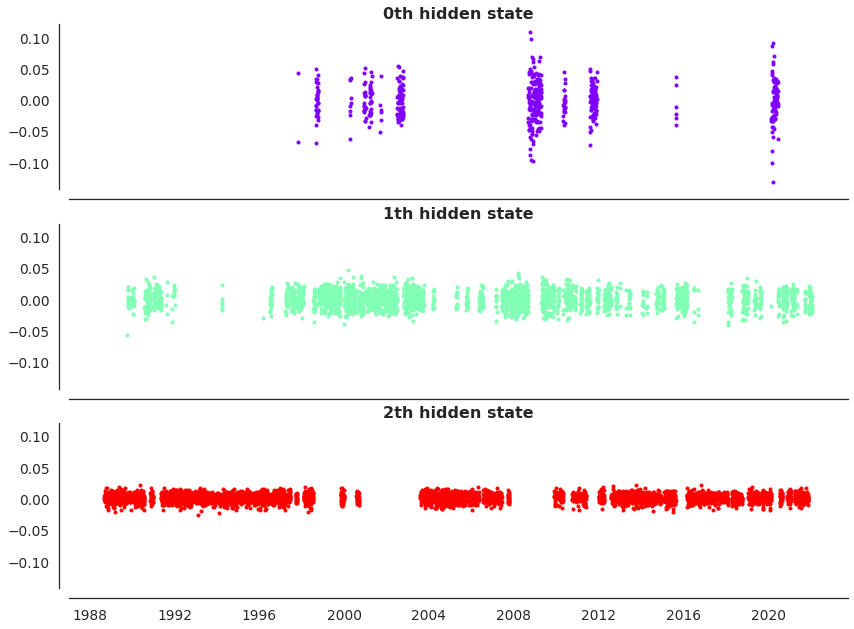

In [12]:
ft_cols = ['ret1d']
X = russel_df[ft_cols].values

model = hmm.GaussianHMM(n_components=3, 
                        covariance_type="diag", 
                        n_iter=100).fit(X)

hidden_states = model.predict(X)

# 打印每个状态的 mean & var
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

# 画图    
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(russel_df.index.values[mask],
                 russel_df['ret1d'].values[mask],
                 ".", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')